# 2024/08/01

In [3]:
from lib.Gridworld import Gridworld

''' 
    game mode
    static = gridworld 위의 모든 객체(플레이어, 장애물, 함정, 도착점)의 위치가 고정,
    player = static 모드와 같으나 플레이어의 위치가 무작위로 설정됨,
    random = gridworld 위의 모든 객체(플레이어, 장애물, 함정, 도착점)의 위치가 무작위로 설정
'''
game = Gridworld(size=4, mode="static")

In [4]:
'''
    u : up,
    d : down,
    r : right,
    l : left
'''
game.makeMove("d")
game.makeMove("d")
game.makeMove("l")
game.display()

array([['+', '-', ' ', ' '],
       [' ', 'W', ' ', ' '],
       [' ', ' ', 'P', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

In [7]:
print(game.reward())
game.board.render_np() # 4 x 4 x 4 형태의 행렬로, 인덱스 0부터 "플레이어의 위치", "도착점의 위치", "함정의 위치", "장애물의 위치"이다

-1


array([[[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 0]],

       [[1, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]], dtype=uint8)

In [23]:
### import numpy as np
import torch
from torch import nn
from lib.Gridworld import Gridworld
from IPython.display import clear_output
import random
import matplotlib.pyplot as plt
import numpy as np
import time

# l = layer
l1 = 64 # 64차원의 벡터를 입력으로 받는다
l2 = 150 # 첫번째 은닉층의 노드 수
l3 = 100 # 두번째 은닉층의 노드 수
l4 = 4 # 출력층의 노드 수(4차원의 실수 벡터를 반환한다)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device type :", device)
print("current device :", torch.cuda.current_device())
print("number of device :", torch.cuda.device_count())

''' 모델 구현 '''
model = nn.Sequential(
    nn.Linear(l1, l2),
    nn.ReLU(),
    nn.Linear(l2, l3),
    nn.ReLU(),
    nn.Linear(l3, l4)
).to(device)
loss_fn = nn.MSELoss()
lr = 1e-3 # 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

gamma = 0.9
epsilon = 1.0

action_set = {
    0: "u",
    1: "d",
    2: "l",
    3: "r"
}

epochs = 1000
losses = []
start = time.time()
for i in range(epochs):
    game = Gridworld(size=4, mode="static") # 4 X 4 크기의 보드 게임을 사용한다

    ''' 초기 상태 처리 '''
    # 4 X 4 X 4 형태의 벡터를 1 X 64 형태의 벡터로 평활화한다
    state_ = game.board.render_np().reshape(1, 64) \
            + np.random.rand(1, 64) / 10.0 # ReLU() 함수의 0이하의 값은 모두 0으로 사상하는 특성으로 인한 "dead neuron" 현상을 막기위해 잡음을 추가한다
    # state = torch.tensor(state_, dtype=torch.float, device=device) # 이게 아래 코드보다 훨씬 느리다
    state = torch.from_numpy(state_).float().to(device)

    ''' 게임 진행 '''
    status = 1 # 게임 종료 여부; 1 = 진행중 / 0 = 종료
    while(status == 1):
        qval = model(state) # Q 값으로 구성된 벡터 출력
        # qval_ = qval.data.numpy()

        ''' 행동(동작) 선택 및 실행 '''
        if(random.random() < epsilon): # 탐험(exploration)
            action_ = torch.randint(0, 4, (1,)).item() # 무작위로 행동을 선택한다
        else: # 활용(exploitation)
            action_ = torch.argmax(qval, dim=1).item() # 가장 큰 Q 값을 가진 행동을 선택한다
        action = action_set[action_]
        game.makeMove(action)

        ''' 다음 상태(S_t+1)와 보상(R_t+1) '''
        state2_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 10.0
        state2 = torch.from_numpy(state2_).float().to(device)
        reward = game.reward() # reward는 int형(텐서가 아니다) 객체이다
        
        ''' max Q 계산 및 Q-러닝의 label(목표값, 실제값) 항 계산 '''
        # 다음 상태(S_t+1)가 아닌 현재 상태(S_t)에 대해 모델을 학습시키는 것이므로,
        # 계산 그래프에서 다음 상태에 대한 Q 값 계산을 제외시킨다
        with torch.no_grad():
            newQ = model(state2)
        maxQ = torch.max(newQ) # 스칼라 텐서이다
        if reward == -1: # 다음 상태가 존재할 경우(게임(에피소드)이 아직 끝나지 않음)
            Y = reward + (gamma * maxQ)
        else: # 다음 상태가 더 이상 없을 경우(게임(에피소드)이 종료됨)
            Y = reward
            status = 0 # 게임이 종료되었으므로 while문을 종료한다
        # Y는 크기가 1인 (스칼라)텐서이므로 1차원 텐서로 만들어준다
        # Y의 계산 과정에 모델의 출력값이 있으므로, Y에 대한 계산 그래프가 생성된다
        # 따라서 Y에 대한 계산 그래프에 대하여 역전파를 수행하지 않도록 Y를 계산 그래프에서 배제한다
        # 물론 지금은 Y 값 계산을 위한 모델 출력을 구할 때 torch.no_grad()를 사용했으므로 굳이 detach()를 사용할 필요는 없다
        Y = torch.tensor([Y], dtype=torch.float, device=device).detach()

        ''' Q-러닝 수행 '''
        # qval은 1 X 4 형태의 텐서이고 squeeze()를 수행하면 크기가 4인 (배열과 같은)텐서가 된다
        X = qval.squeeze()[action_].unsqueeze(dim=0) # Q 값에서 현재 취한 행동에 대한 행동 가치를 반환한다
        loss = loss_fn(X, Y)
        loss_ = loss.item()
        losses.append(loss_)
        # print(i, loss_)
        # clear_output(wait=True) # 옆의 코드를 사용하면 쥬피터 셀의 실행 결과가 밑으로 계속 나열되지 않고 갱신이 이루어진다
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        ''' 상태 갱신(S_t ==> S_t+1) '''
        state1 = state2

    print(f"process status : {i}")
    clear_output(wait=True)
    ''' epsilon 갱신 '''
    if epsilon > 0.1:
        epsilon -= (1 / epochs)
end = time.time()
print(f"running time : {(end - start) / 60:.3f} min")
# running time : 4.888 min
# running time : 3.267 min
# running time : 3.131 min

running time : 3.131 min


Text(0, 0.5, 'Loss')

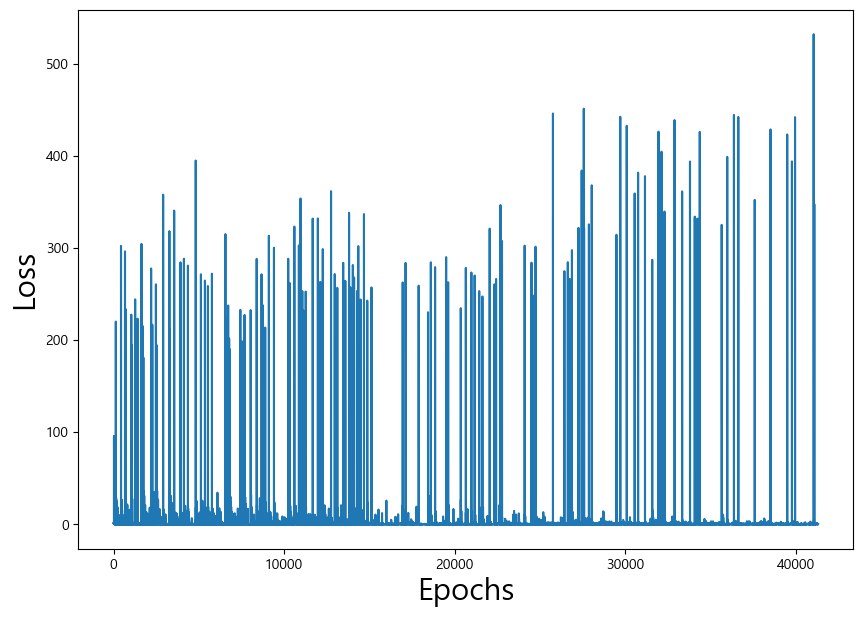

In [24]:
plt.figure(figsize=(10, 7))
plt.plot(losses)
plt.xlabel("Epochs", fontsize=22)
plt.ylabel("Loss", fontsize=22)

In [25]:
def test_model(model, mode="static", display=True):
    i = 0 # 취한 행동 개수

    ''' 환경 생성 '''
    test_game = Gridworld(mode=mode) # 환경 생성(기본이 4 X 4 형식인 것 같다)

    ''' 초기 상태 계산 '''
    state_ = test_game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 10.0
    # state = torch.tensor(state_, dtype=torch.float, device=device) # 이게 아래 코드보다 훨씬 느리다
    state = torch.from_numpy(state_).float().to(device)

    ''' 게임(에피소드) 실행 '''
    status = 1 # 게임 종료 여부
    while(status == 1):
        qval = model(state) # 행동 가치 벡터 계산

        ''' 행동 선택 및 실행 '''
        action_ =  torch.argmax(qval, dim=1).item()
        action = action_set[action_]
        game.makeMove(action)
        if display: # 취한 행동 표시
            print('Move #: %s; Taking action: %s' % (i, action))
        test_game.makeMove(action)

        ''' 상태 갱신 '''
        state_ = test_game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 10.0
        state = torch.from_numpy(state_).float().to(device)
        if display: # 게임 상태 표시
            print(test_game.display())

        ''' 보상 계산 '''
        reward = test_game.reward()        
        if reward != -1: # 게임이 종료 되었는지 여부를 확인
            if reward > 0: # 도착점에 도착해서 +10점을 받은 경우
                status = 2 # 게임에서 승리했음을 의미한다
                if display:
                    print("Game won!, Reward: %s" % (reward))
            else: # 함정에 도착해서 -10점을 받은 경우
                status = 0 # 게임에서 패배했음을 의미한다
                if display:
                    print("Game Lost!, Reward: %s" % (reward))

        i += 1 # 취한 행동의 횟수 갱신
        if i > 15: # 너무 많은 행동을 취한 경우
            if display:
                print("Game Lost!, too many moves.")
            break
        
    win = True if status == 2 else False
    return win

start = time.time()
test_model(model, "static")
end = time.time()
print(f"running time : {(end - start) / 60:.3f} min")

Move #: 0; Taking action: l
[['+' '-' 'P' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 1; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Game Lost!, Reward: -10
running time : 0.004 min


In [9]:
l1 = 64
l2 = 150
l3 = 100
l4 = 4

model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3,l4)
)
loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

gamma = 0.9
epsilon = 1.0
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

gamma = 0.9
epsilon = 1.0

action_set = {
    0: 'u',
    1: 'd',
    2: 'l',
    3: 'r',
}

epochs = 1000
losses = [] #A
start = time.time()
for i in range(epochs): #B
    game = Gridworld(size=4, mode='static') #C
    state_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0 #D
    state = torch.from_numpy(state_).float() #E
    status = 1 #F
    while(status == 1): #G
        qval = model(state) #H
        qval_ = qval.data.numpy()
        if (random.random() < epsilon): #I
            action_ = np.random.randint(0,4)
        else:
            action_ = np.argmax(qval_)
        
        action = action_set[action_] #J
        game.makeMove(action) #K
        state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
        state2 = torch.from_numpy(state2_).float() #L
        reward = game.reward()
        with torch.no_grad():
            newQ = model(state2.reshape(1,64))
        maxQ = torch.max(newQ) #M
        if reward == -1: #N
            Y = reward + (gamma * maxQ)
        else:
            Y = reward
        Y = torch.Tensor([Y]).detach()
        X = qval.squeeze()[action_] #O
        loss = loss_fn(X, Y) #P
        # print(i, loss.item())
        # clear_output(wait=True)
        optimizer.zero_grad()
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        state1 = state2
        if reward != -1: #Q
            status = 0
    print(f"process status : {i}")
    clear_output(wait=True)
    if epsilon > 0.1: #R
        epsilon -= (1/epochs)
end = time.time()
print(f"running time : {(end - start) / 60:.3f} min")

plt.figure(figsize=(10, 7))
plt.plot(losses)
plt.xlabel("Epochs", fontsize=22)
plt.ylabel("Loss", fontsize=22)

RuntimeError: Trying to create tensor with negative dimension -10: [-10]

In [ ]:
def test_model(model, mode="static", display=True):
    i = 0 # 취한 행동 개수

    ''' 환경 생성 '''
    test_game = Gridworld(mode=mode) # 환경 생성(기본이 4 X 4 형식인 것 같다)

    ''' 초기 상태 계산 '''
    state_ = test_game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 10.0
    state = torch.from_numpy(state_).float()

    ''' 게임(에피소드) 실행 '''
    status = 1 # 게임 종료 여부
    while(status == 1):
        qval = model(state) # 행동 가치 벡터 계산
        qval_ = qval.data.numpy()

        ''' 행동 선택 및 실행 '''
        action_ = np.argmax(qval_)
        action = action_set[action_]
        game.makeMove(action)
        if display: # 취한 행동 표시
            print('Move #: %s; Taking action: %s' % (i, action))
        test_game.makeMove(action)

        ''' 상태 갱신 '''
        state_ = test_game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 10.0
        state = torch.from_numpy(state_).float()
        if display: # 게임 상태 표시
            print(test_game.display())

        ''' 보상 계산 '''
        reward = test_game.reward()        
        if reward != -1: # 게임이 종료 되었는지 여부를 확인
            if reward > 0: # 도착점에 도착해서 +10점을 받은 경우
                status = 2 # 게임에서 승리했음을 의미한다
                if display:
                    print("Game won!, Reward: %s" % (reward))
            else: # 함정에 도착해서 -10점을 받은 경우
                status = 0 # 게임에서 패배했음을 의미한다
                if display:
                    print("Game Lost!, Reward: %s" % (reward))

        i += 1 # 취한 행동의 횟수 갱신
        if i > 15: # 너무 많은 행동을 취한 경우
            if display:
                print("Game Lost!, too many moves.")
            break
        
    win = True if status == 2 else False
    return win

start = time.time()
test_model(model, "static")
end = time.time()
print(f"running time : {(end - start) / 60:.3f} min")